## LightGBM

**LightGBM** is a relatively new Gradient boosting library. Its has the following algorithmic improvements which give it good performance advantages. 
1. Gradient-based One-Side Sampling (GOSS) - GOSS excludes significant proportion of data instances with small gradients, and only uses rest to estimate the information gain.
2. Exclusive Feature Bundling (EFB) - With EFB mutually exclusive features (which rarely take non zero values simultaneously) are bundled together.
3. LightGBM can use categorical data directly without one-hot-encoding.

https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf

Together with these algorithmic improvements authors show they can get almost 10x speed up over **xgBoost** hist runs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Make the sheet width 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>" ))

Load bank marketing dataset 

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

In [2]:
df=pd.read_csv("../data/bank/bank-additional-full.csv", sep=';')
print(df.shape)

(41188, 21)


In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
#Check if there is missing data
df.isnull().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

No missing data

In [9]:
#Numerical and categorical columns
#Dataset is a mixture of categorical and numerical features
numerical_columns = df.select_dtypes(exclude=['object']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns[:-1]

print(f"Number of numerical features {len(numerical_columns)}")
print(f"Number of categorical features {len(categorical_columns)}")

Number of numerical features 10
Number of categorical features 10


In [10]:
#List categorical variables
for c in categorical_columns:
    print(f"column={c} {df[c].unique()}")

column=job ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
column=marital ['married' 'single' 'divorced' 'unknown']
column=education ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
column=default ['no' 'unknown' 'yes']
column=housing ['no' 'yes' 'unknown']
column=loan ['no' 'yes' 'unknown']
column=contact ['telephone' 'cellular']
column=month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
column=day_of_week ['mon' 'tue' 'wed' 'thu' 'fri']
column=poutcome ['nonexistent' 'failure' 'success']


In [11]:
#Lets look at the distribution of target
df['y'].value_counts()

#data is unbalanced with 90% of the entries as no and only 10% as yes.
#So a naive classifier which predicts everything as no will have 90% accuracy

no     36548
yes     4640
Name: y, dtype: int64

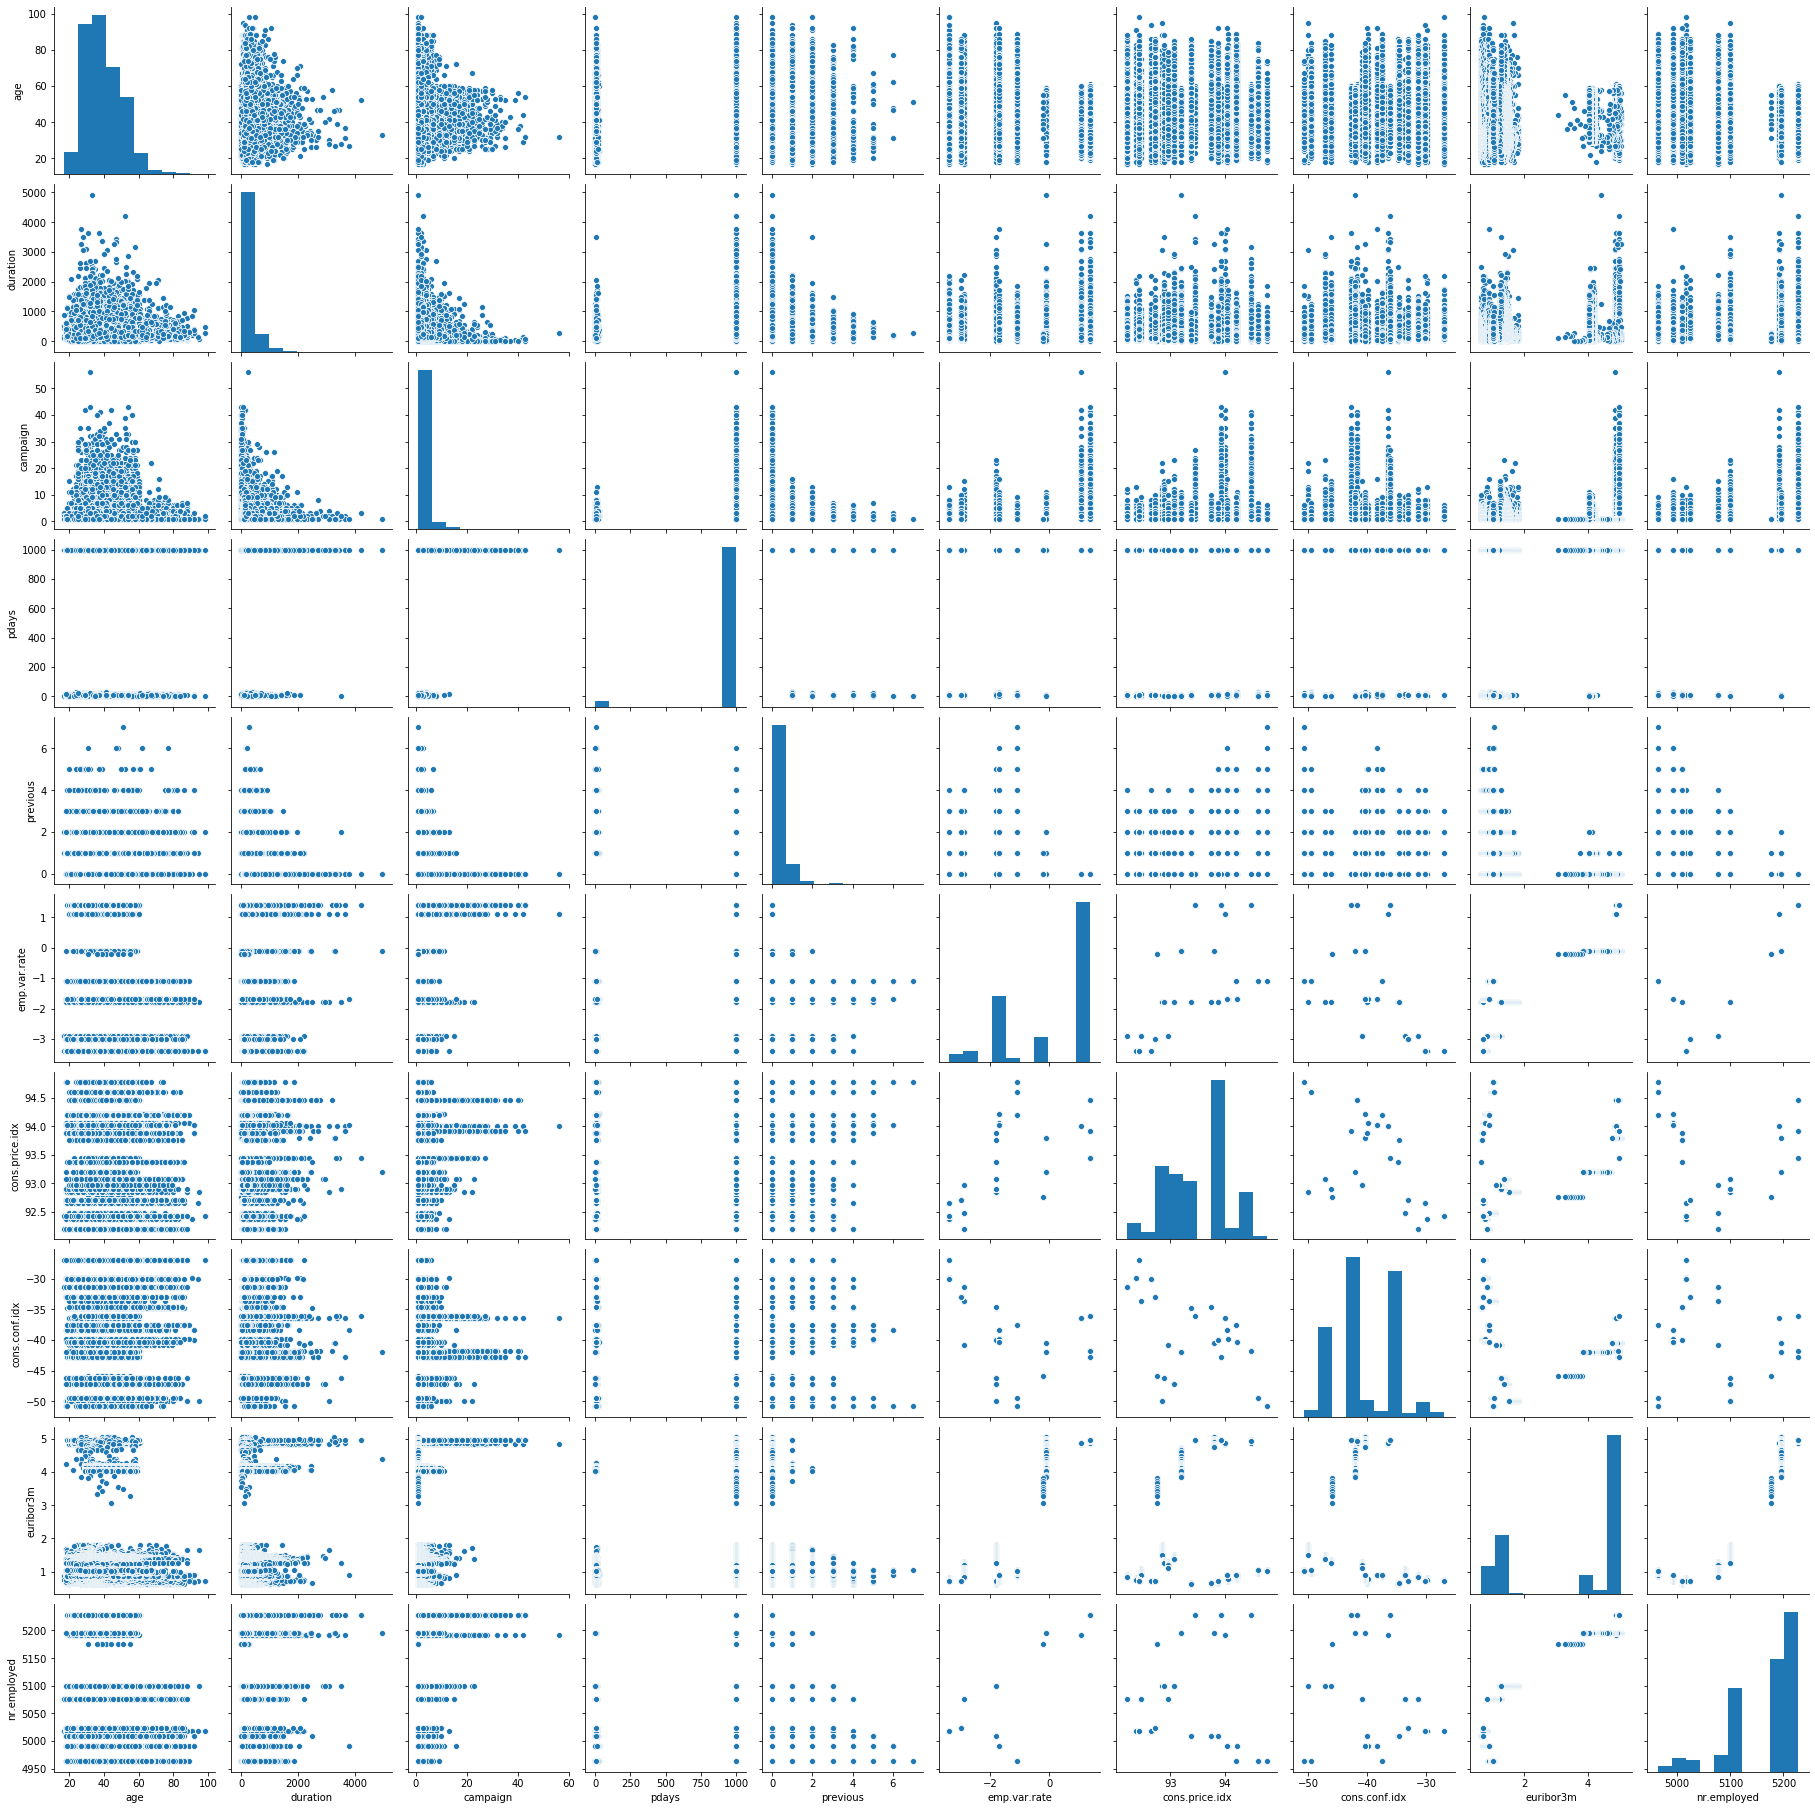

In [12]:
#Lets plot the numerical features
import seaborn as sns
df_num = df[numerical_columns]
sns.pairplot(df_num)

In [13]:
#Now lets apply one hot encoding to categorical columns
def applyOneHot(df, cat_columns):
    onehot_df = df[cat_columns]
    onehot_df = pd.get_dummies(onehot_df, columns = cat_columns)
    onehot_drop = df.drop(cat_columns, axis = 1)
    ret = pd.concat([onehot_drop, onehot_df], axis = 1)
    return ret

df_one_hot = applyOneHot(df, categorical_columns)
print(df_one_hot.shape)

(41188, 64)


In [14]:
#Lets apply LabelEncoder for the y
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_one_hot['y'])
y_label = pd.DataFrame(le.transform(df_one_hot['y']), columns=['y'])
df_one_hot.drop('y', axis=1, inplace=True)
df_one_hot = pd.concat([df_one_hot, y_label], axis=1)

In [15]:
#Lets do train test split
X = df_one_hot.drop('y', axis=1)
y = df_one_hot['y']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0 )

print(f"X_train={X_train.shape}")
print(f"y_train={y_train.shape}")
print(f"X_test={X_test.shape}")
print(f"y_test={y_test.shape}")

X_train=(32950, 63)
y_train=(32950,)
X_test=(8238, 63)
y_test=(8238,)


In [16]:
#Lets first apply Logistics regression
#Lets standardize the Xs
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=500)
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=0.91
Test score=0.915


**Logistic regression** gave a score little better than a naive classifier. Lets look at the **Confusion Matrix**.

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
def getStats(y, y_pred):
    #Get the confusion matrix
    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix =", cm)

    TN = cm[0,0]
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]

    #Accuracy score 
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    print(f"Accuracy = {accuracy:.2}")

    error = (FP + FN)/(TP + TN + FP + FN)
    print(f"Error = {error:.2}")

    #Precision
    precision = (TP / (TP + FP))
    print(f"Precision = {precision:.2}")

    #Recall
    recall = (TP / (TP + FN))
    print(f"Recall = {recall:.2}")

    #F1 score
    f1 = 2 * recall * precision / ( recall + precision )
    print(f"F1 = {f1:.2}")

    #True Positive Rate
    TPR = (TP /(TP + FN))
    print(f"TPR = {TPR:.2}")

    #Flass positive rate
    fpr = ( FP / (FP + TN))
    print(f"FPR = {fpr:.2}")
    
y_pred_test = clf.predict(X_test_std)
getStats(y_test, y_pred_test)

Confusion Matrix = [[7109  210]
 [ 489  430]]
Accuracy = 0.92
Error = 0.085
Precision = 0.67
Recall = 0.47
F1 = 0.55
TPR = 0.47
FPR = 0.029


Not very good precision and recall

In [18]:
#Lets apply random forest
#Now lets fit random forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, min_samples_split=2)
clf.fit(X_train, y_train)
print(f"Train score={clf.score(X_train, y_train):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

Train score=1.0
Test score=0.918


Random Forest seems to be overfitting this dataset

In [19]:
y_pred_test = clf.predict(X_test)
getStats(y_test, y_pred_test)

Confusion Matrix = [[7111  208]
 [ 469  450]]
Accuracy = 0.92
Error = 0.082
Precision = 0.68
Recall = 0.49
F1 = 0.57
TPR = 0.49
FPR = 0.028


In [20]:
#Lets use default XgBoost parameters
import xgboost as xgb
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
print(f"Train score={clf.score(X_train, y_train):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

y_pred_test = clf.predict(X_test)
getStats(y_test, y_pred_test)

Train score=0.959
Test score=0.917
Confusion Matrix = [[7043  276]
 [ 404  515]]
Accuracy = 0.92
Error = 0.083
Precision = 0.65
Recall = 0.56
F1 = 0.6
TPR = 0.56
FPR = 0.038


Default **xgBoost** doesn't give very good performance on the dataset.
Train and test score are both low.
Lets do some hyperparameter tuning of **xgBoost**.

In [60]:
from sklearn.model_selection import GridSearchCV
# A parameter grid for XGBoost
params = {
        'learning_rate' : [ 0.1, 1],
        'gamma': [0, 1, 2, 10],
        'max_depth': [5, 6, 10],
        'reg_lambda': [0.01, 0.1, 1, 2],
        'n_estimators': [100, 500, 1000]
        }
clf = xgb.XGBClassifier(tree_method='hist')
gs = GridSearchCV(clf, 
                    param_grid=params, 
                    scoring='accuracy',  
                    cv=10,
                    n_jobs=1)
gs = gs.fit(X_train, y_train)

print(f"Best score = {gs.best_score_:.3}")
print(gs.best_params_)

Best score = 0.917
{'gamma': 10, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'reg_lambda': 2}


In [63]:
#Lets use default XgBoost parameters
import xgboost as xgb
clf = xgb.XGBClassifier(gamma=10,
                       learning_rate=0.1,
                       max_depth=10,
                       n_estimators=100,
                       reg_lambda=2)
clf.fit(X_train, y_train)
print(f"Train score={clf.score(X_train, y_train):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

y_pred_test = clf.predict(X_test)
getStats(y_test, y_pred_test)

Train score=0.924
Test score=0.922
Confusion Matrix = [[7070  249]
 [ 395  524]]
Accuracy = 0.92
Error = 0.078
Precision = 0.68
Recall = 0.57
F1 = 0.62
TPR = 0.57
FPR = 0.034


In [21]:
#Lets apply LightGBM using just the default settings
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
print(f"Train score={clf.score(X_train, y_train):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

y_pred_test = clf.predict(X_test)
getStats(y_test, y_pred_test)

Train score=0.939
Test score=0.923
Confusion Matrix = [[7068  251]
 [ 380  539]]
Accuracy = 0.92
Error = 0.077
Precision = 0.68
Recall = 0.59
F1 = 0.63
TPR = 0.59
FPR = 0.034


Out of the box **LightGBM** performs better than **xgBoost**.

Now lets compare *hist* of **xgBoost**, *gbdt* and *goss* of **LightGBM**.

In [28]:
%%timeit
#Hist search
clf = xgb.XGBClassifier(tree_method='hist',
                       learning_rate=0.1,
                       max_depth=8,
                       n_estimators=500,
                       min_child_weight=100)
clf.fit(X_train_std, y_train)
print(f"Train score={clf.score(X_train_std, y_train):.3}")
print(f"Test score={clf.score(X_test_std, y_test):.3}")

Train score=0.93
Test score=0.92
Train score=0.93
Test score=0.92
Train score=0.93
Test score=0.92
Train score=0.93
Test score=0.92
Train score=0.93
Test score=0.92
Train score=0.93
Test score=0.92
Train score=0.93
Test score=0.92
Train score=0.93
Test score=0.92
4.51 s ± 444 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                        learning_rate=0.1,
                        max_depth=8,
                        n_estimators=500,
                        min_child_weight=100)
clf.fit(X_train, y_train)
print(f"Train score={clf.score(X_train, y_train):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

Train score=0.931
Test score=0.922
Train score=0.931
Test score=0.922
Train score=0.931
Test score=0.922
Train score=0.931
Test score=0.922
Train score=0.931
Test score=0.922
Train score=0.931
Test score=0.922
Train score=0.931
Test score=0.922
Train score=0.931
Test score=0.922
4.99 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%timeit
clf = lgb.LGBMClassifier(boosting_type='goss',
                        learning_rate=0.1,
                        max_depth=8,
                        n_estimators=500,
                        min_child_weight=100)
clf.fit(X_train, y_train)
print(f"Train score={clf.score(X_train, y_train):.3}")
print(f"Test score={clf.score(X_test, y_test):.3}")

Train score=0.933
Test score=0.923
Train score=0.933
Test score=0.923
Train score=0.933
Test score=0.923
Train score=0.933
Test score=0.923
Train score=0.933
Test score=0.923
Train score=0.933
Test score=0.923
Train score=0.933
Test score=0.923
Train score=0.933
Test score=0.923
4.94 s ± 922 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Above we don't see much speed up with *goss* of **LightGBM**.

Another advantage of LightGBM is we dont have to do one hot encoding of data. Lets try that out

In [33]:
df_no_one_hot = df.copy()

In [39]:
#Lets apply LabelEncoder for the y
from sklearn import preprocessing

def applyLabel(df, cat_columns):
    for c in cat_columns:
        le = preprocessing.LabelEncoder()
        le.fit(df[c])
        label = pd.DataFrame(le.transform(df[c]), columns=[c])
        df.drop(c, axis=1, inplace=True)
        df = pd.concat([df, label], axis=1)
    return df
categorical_columns = np.append(categorical_columns, np.array(['y']))
df_no_one_hot = applyLabel(df_no_one_hot, categorical_columns)

In [40]:
df_no_one_hot.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,0,1,6,1,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,3,1,0,0,1,6,1,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,3,0,2,0,1,6,1,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,1,0,0,0,1,6,1,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,3,0,0,2,1,6,1,1,0


In [41]:
#Lets do train test split
X_noh = df_no_one_hot.drop('y', axis=1)
y_noh = df_no_one_hot['y']

from sklearn.model_selection import train_test_split
X_noh_train, X_noh_test, y_noh_train, y_noh_test = train_test_split(X_noh, y_noh, test_size=0.20, random_state=0)

print(f"X_train={X_noh_train.shape}")
print(f"y_train={y_noh_train.shape}")
print(f"X_test={X_noh_test.shape}")
print(f"y_test={y_noh_test.shape}")

X_train=(32950, 20)
y_train=(32950,)
X_test=(8238, 20)
y_test=(8238,)


In [58]:
%%timeit
import warnings
warnings.filterwarnings('ignore')

clf = lgb.LGBMClassifier(boosting_type='goss',
                        learning_rate=0.1,
                        max_depth=8,
                        n_estimators=500,
                        min_child_weight=100)
clf.fit(X_noh_train, y_noh_train, 
        feature_name=df_no_one_hot.drop('y', axis=1).columns.values.tolist(), 
        categorical_feature=categorical_columns[:-1].tolist())
print(f"Train score={clf.score(X_noh_train, y_noh_train):.3}")
print(f"Test score={clf.score(X_noh_test, y_noh_test):.3}")

Train score=0.939
Test score=0.92
Train score=0.939
Test score=0.92
Train score=0.939
Test score=0.92
Train score=0.939
Test score=0.92
Train score=0.939
Test score=0.92
Train score=0.939
Test score=0.92
Train score=0.939
Test score=0.92
Train score=0.939
Test score=0.92
8.03 s ± 1.98 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Model accuracy stays pretty much the same speed goes down when we don't use on hot encoding

In [61]:
#Now lets go gridsearch on LightGBM parameters to find a good set of parameters

In [66]:
# A parameter grid for LightGBM
params = {
        'learning_rate' : [ 0.1, 1],
        'min_split_gain': [0, 1, 2, 10],
        'max_depth': [5, 6, 10],
        'reg_lambda': [0.01, 0.1, 1, 2],
        'n_estimators': [100, 500, 1000]
        }
clf = lgb.LGBMClassifier(boosting_type='goss', num_leaves=1024)
gs = GridSearchCV(clf, 
                    param_grid=params, 
                    scoring='accuracy',  
                    cv=10,
                    n_jobs=1)
gs = gs.fit(X_train, y_train)

print(f"Best score = {gs.best_score_:.3}")
print(gs.best_params_)

Best score = 0.917
{'learning_rate': 0.1, 'max_depth': 5, 'min_split_gain': 2, 'n_estimators': 500, 'reg_lambda': 0.1}


In [69]:
clf = lgb.LGBMClassifier(boosting_type='goss', 
                        num_leaves=1024,
                        learning_rate=0.1,
                        max_depth=5,
                        min_split_gain=2,
                        n_estimators=500,
                        reg_lambda=0.1)
clf.fit(X_noh_train, y_noh_train, 
        feature_name=df_no_one_hot.drop('y', axis=1).columns.values.tolist(), 
        categorical_feature=categorical_columns[:-1].tolist())
print(f"Train score={clf.score(X_noh_train, y_noh_train):.3}")
print(f"Test score={clf.score(X_noh_test, y_noh_test):.3}")
y_pred_test = clf.predict(X_noh_test)
getStats(y_test, y_pred_test)

Train score=0.931
Test score=0.921
Confusion Matrix = [[7063  256]
 [ 396  523]]
Accuracy = 0.92
Error = 0.079
Precision = 0.67
Recall = 0.57
F1 = 0.62
TPR = 0.57
FPR = 0.035


#### we can see from the above sheet LightGBM has very similar performance to xgBoost